# Tomo Challenge Sandbox

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tomo_challenge as tc

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


In [3]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import jax_cosmo.sparse as sparse

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


## Challenge Data

Specify options for loading the data:

In [5]:
bands='riz'
include_colors=True
include_errors=True

Load the training data:

In [6]:
training_file=f'/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
train_data_arr = tc.load_data(training_file, bands, 
                             errors=include_errors,
                             colors=include_errors, array=True)
training_z = tc.load_redshift(training_file)
print(f'Loaded {len(train_data_arr)} training rows.')

/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Loaded 8615613 training rows.


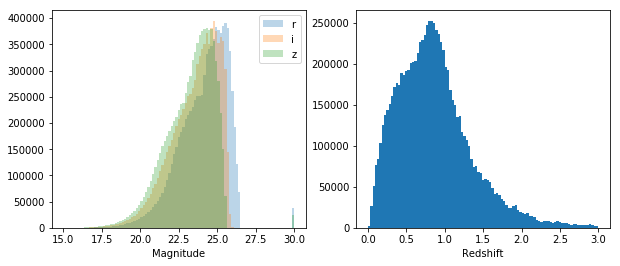

In [7]:
def plot_train():
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for band, idx in zip(bands, (0, 1, 2)):
        ax[0].hist(train_data_arr[:, idx], bins=np.linspace(15, 30, 100), label=band, alpha=0.3)
    ax[0].legend()
    ax[0].set_xlabel('Magnitude')
    ax[1].hist(training_z, bins=np.linspace(0, 3, 100))
    ax[1].set_xlabel('Redshift')
    
plot_train()

Load the validation data:

In [8]:
validation_file=f'/media/data2/tomo_challenge_data/ugrizy/validation.hdf5'
valid_data_arr = tc.load_data(validation_file, bands, 
                              errors=include_errors,
                              colors=include_errors, array=True)
val_z = tc.load_redshift(validation_file)
print(f'Loaded {len(valid_data_arr)} validation rows.')

Loaded 17228554 validation rows.


Calculate percentile bins of redshift:

In [11]:
def get_zedges(z, n):
    return np.percentile(z, np.linspace(0, 100, n + 1))

zedges = get_zedges(training_z, 20)

## Random Forest Example

In [12]:
nbins_rf = 4
ntrain_rf = 20000
nvalid_rf = 50000

In [13]:
classifier = tc.Tomographer._find_subclass('RandomForest')(bands, {'bins': nbins_rf})

In [14]:
classifier.train(train_data_arr[:ntrain_rf], training_z[:ntrain_rf])

Finding bins for training data
Fitting classifier


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
idx_rf = classifier.apply(valid_data_arr[:nvalid_rf])
z_rf = val_z[:nvalid_rf]

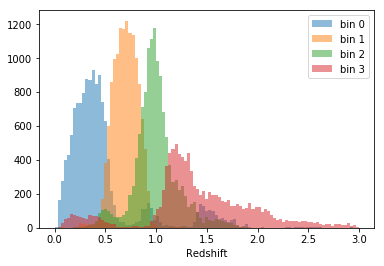

In [16]:
def plot_rf_bins():
    zbins = np.linspace(0, 3, 100)
    for bin in range(nbins_rf):
        plt.hist(z_rf[idx_rf == bin], zbins, alpha=0.5, label=f'bin {bin}')
    plt.legend()
    plt.xlabel('Redshift')
    
plot_rf_bins()

In [19]:
%time scores_rf = tc.jc_compute_scores(results, z_rf, metrics='all') #['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 3min 2s, sys: 21.5 s, total: 3min 24s
Wall time: 3min 40s


In [20]:
scores_rf

{'SNR_ww': 347.01068115234375,
 'FOM_ww': 25.575666427612305,
 'FOM_DETF_ww': 0.7120426297187805,
 'SNR_gg': 1172.628173828125,
 'FOM_gg': 608.364013671875,
 'FOM_DETF_gg': 6.4218525886535645,
 'SNR_3x2': 1174.98095703125,
 'FOM_3x2': 2074.23828125,
 'FOM_DETF_3x2': 48.22594451904297}

## Jax-Cosmo Calculations

### Initialization

Define the fiducial cosmology and ell binning:

In [17]:
cosmo = jc.Cosmology(
    Omega_c = 0.27,
    Omega_b = 0.045,
    h = 0.67,
    n_s = 0.96,
    sigma8 = 0.8404844953840714,
    Omega_k=0.,
    w0=-1., wa=0.)

In [18]:
ell, _ = tc.jax_metrics.ell_binning()

### Random Forest Calculations

Calculate $\mu$ and $C$ for the random-forest results:

In [21]:
onehot_rf = jax.nn.one_hot(idx_rf, idx_rf.max() + 1)
probes_rf = tc.jax_metrics.get_probes(onehot_rf, z_rf, what='gg')

In [23]:
%time cl_rf = jc.angular_cl.angular_cl(cosmo, ell, probes_rf)

CPU times: user 5.39 s, sys: 278 ms, total: 5.66 s
Wall time: 5.1 s


In [28]:
nl_rf = jc.angular_cl.noise_cl(ell, probes_rf)

In [26]:
#%time mu, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, f_sky=0.25, nonlinear_fn=jc.power.halofit, sparse=True)

In [29]:
cl_rf.shape, nl_rf.shape

((10, 100), (10, 100))

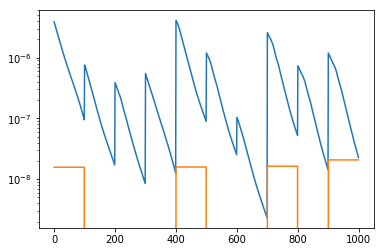

In [31]:
plt.semilogy(cl_rf.reshape(-1));
plt.semilogy(nl_rf.reshape(-1));

In [32]:
#plt.semilogy(np.diag(sparse.to_dense(C)), '-');

## Formalism

Each combination, indexed by $i$, of a probe P_i (WL, number density, etc) and a redshift bin with normalized density $dn_i/dz(z)$ has an associated kernel function $K_i(a, \ell)$. The power spectrum associated with the pair $(i,j)$ is:
$$
c_{i,j}(\ell) = \frac{1}{c^2} \int_0^1 da K_i(a, \ell) K_j(a, \ell) F(a, \ell)
$$
where $F$ depends on the assumed cosmology but not on $i$ or $j$:
$$
F(a, \ell) = P_{NL}\left(\frac{\ell + 1/2}{\chi(a)}, a\right) \frac{1}{\chi(a)^2} \frac{d\chi}{da}(a) \; .
$$

The kernel is linear in the normalized density so if we combine two redshift bins $a + b \rightarrow ab$ according to
$$
\frac{dn_{ab}}{dz}(z) = \alpha \frac{dn_{a}}{dz}x(z) + \beta \frac{dn_{b}}{dz}(z) \; ,
$$
with $\alpha + \beta = 1$, then
$$
K_{ab}(a, \ell) = \alpha K_a(a, \ell) + \beta K_b(a, \ell)
$$
and
$$
c_{ab,j}(\ell) = \frac{1}{c^2} \int_0^1 da \left[ \alpha K_a(a, \ell) + \beta K_b(a, \ell) \right] K_j(a, \ell) F(a, \ell)
= \alpha c_{a,j}(\ell) + \beta c_{b,j}(\ell) \; .
$$

More generally, suppose we define new redshift bins for each probe that are linear combinations of the original redshift bins (for the same probe):
$$
\frac{dn'_i}{dz} = \left. \sum_j M_{ij} \frac{dn_j}{dz} \middle/ \sum_j M_{ij} \right. = \sum_j \tilde{M}_{ij} \frac{dn_j}{dz}
$$
with
$$
\tilde{M}_{ij} \equiv \frac{M_{ij}}{\sum_p M_{ip}} \; .
$$

then, in matrix notation,
$$
\mathbf{K}'(a, \ell) = \tilde{M}\cdot \mathbf{K}(a, \ell)
$$
and
$$
\mathbf{c}'(\ell) = \frac{1}{c^2} \int_0^1 da
\left[ \tilde{M}\cdot \mathbf{K}(a, \ell) \right]
\left[ \tilde{M}\cdot \mathbf{K}(a, \ell) \right]^T F(a, \ell)
= \tilde{M}\cdot \mathbf{c}(\ell) \cdot \tilde{M}^T \; .
$$

Note that the matrix $M$ is block diagonal, with blocks corresponding to each probe, since the new bins do not mix probes.

The noise power for the new bins is:
$$
\mathbf{n}'(\ell) = \left[ W \cdot \mathbf{n}(\ell)^{-1}\cdot W^T \right]^{-1}
$$
where the inverse is applied element wise and $W$ are ... (see code below)

The kernel for the galaxy number density probe is:
$$
K(a, \ell) = \frac{dn}{dz}(z(a)) b(a) H(a)
$$
and for the weak lensing probe (neglecting intrinsic alignments for now):
$$
K(a, \ell) = \frac{3 \Omega_m H_0^2}{2 c} \sqrt{\frac{(\ell - 1) \ell (\ell + 1) (\ell + 2)}{\ell + 1/2}}
\frac{\chi(a)}{a} \int_{z(a)}^\infty dz' \frac{dn}{dz}(z) \frac{\chi(a(z')) - \chi(a)}{\chi(a(z'))}
$$

The signal-to-noise metric is defined as:
$$
\nu^2 = \mu^t C^{-1} \mu \; .
$$
If we break the prediction into blocks $\mu = \begin{bmatrix} \mu_0 & \mu_1 \end{bmatrix}$
with
$$
C^{-1} = \begin{bmatrix}
C^{-1}_{00} & C^{-1}_{01} \\
C^{-1}_{01} & C^{-1}_{11}
\end{bmatrix}
$$
then
$$
\nu^2 = \mu_0^t C^{-1}_{00} \mu_0 + 2 \mu_0^t C^{-1}_{01} \mu_1 + \mu_1^t C^{-1}_{11} \mu_t \; .
$$

Suppose we combine 2 redshift bins for a single probe and define block 0 to contain only the contributions that are affected by this change, resulting in a block 2 after the change, then the resulting change in the metric is:
$$
\Delta \nu^2 = \left[ \mu_0^t C^{-1}_{00} \mu_0 + 2 \mu_0^t C^{-1}_{01} \mu_1 \right] -
\left[ \mu_2^t C^{-1}_{22} \mu_2 + 2 \mu_2^t C^{-1}_{21} \mu_1 \right]
$$

If $\mu$ originally has contributions from $N$ kernels, then it consists of $N(N + 1)/2$ sections, one for each pair of kernels, of which $2N - 1$ belong to $\mu_0$ and the resulting $\mu_2$ has $N - 1$ sections after joining two redshift bins.

## Reweighting

### Old Method

In [33]:
def expand_symmetric(upper, size):
    upper = np.asarray(upper)
    assert len(upper) == size * (size + 1) // 2
    out = np.empty((size, size) + upper.shape[1:], upper.dtype)
    idx = 0
    for i1 in range(size):
        for i2 in range(i1, size):
            out[i1, i2] = upper[idx]
            if i2 > i1:
                out[i2, i1] = upper[idx]
            idx += 1
    return out

In [34]:
def compress_symmetric(full):
    size = len(full)
    assert full.shape[1] == size
    nout = size * (size + 1) // 2
    out = np.empty((nout,) + full.shape[2:], full.dtype)
    idx = 0
    for i1 in range(size):
        for i2 in range(i1, size):
            out[idx] = full[i1, i2]
            idx += 1
    return out

In [35]:
def reweighted_angular_cl(cl_in, probes, weights, noise=False):
    if len(probes) != len(weights):
        raise ValueError('Expected same number of probes and weights.')
    nprobe = len(probes)
    w = [None] * nprobe
    breaks_in, breaks_out = [0], [0]
    for i in range(nprobe):
        P = probes[i]
        W = np.array(weights[i], dtype=float)
        # Check that the number of weights matches the number of zbins for this probe.
        nout, nin = W.shape
        if nin != P.n_tracers:
            raise ValueError(f'Weight dimension does not match number of zbins for probe[{i}].')
        breaks_in.append(breaks_in[-1] + nin)
        breaks_out.append(breaks_out[-1] + nout)
        if not noise:
            # Include the relative normalizations of each original zbin.
            W *= np.array([pz.gals_per_steradian for pz in P.params[0]])
            W /= np.sum(W, axis=1, keepdims=True)
        print(f'probe[{i}]:\n', np.round(W, 4))
        w[i] = W
    # Check that cl has the expected dimensions.
    cl_in = np.array(cl_in)
    ncl, nell = cl_in.shape
    nin = breaks_in[-1]
    assert ncl == (nin * (nin + 1)) // 2
    if noise:
        np.divide(1, cl_in, where=cl_in != 0, out=cl_in)
    # Expand the input cls into a symmetric matrix.
    cl_in = expand_symmetric(cl_in, nin)
    # Allocate memory for the output cls as a symmetric matrix.
    nout = breaks_out[-1]
    cl_out = np.empty((nout, nout, nell), dtype=cl_in.dtype)
    # Loop over pairs of probes. Although we allocate memory for the full
    # matrix, we only need to fill blocks on and above the diagonal.
    for i1 in range(nprobe):
        S1in = slice(breaks_in[i1], breaks_in[i1 + 1])
        S1out = slice(breaks_out[i1], breaks_out[i1 + 1])
        for i2 in range(i1, nprobe):
            S2in = slice(breaks_in[i2], breaks_in[i2 + 1])
            S2out = slice(breaks_out[i2], breaks_out[i2 + 1])
            cl_out[S1out, S2out] = np.einsum('ip,pqk,jq->ijk', w[i1], cl_in[S1in, S2in], w[i2])
    # Compress the symmetric output cls.
    cl_out = compress_symmetric(cl_out)
    if noise:
        np.divide(1, cl_out, where=cl_out != 0, out=cl_out)
    return cl_out

### New Method

In [123]:
def init_reweighting(probes, cl):
    """
    """
    nprobe = len(probes)
    ncl, nell = cl.shape
    nzbin = np.array([probe.n_tracers for probe in probes])
    breaks = np.concatenate(([0], np.cumsum(nzbin)))
    nztot = breaks[-1]
    assert ncl == nztot * (nztot + 1) // 2
    ngals = [np.array([pz.gals_per_arcmin2 for pz in probe.params[0]]) for probe in probes]
    noise = [ np.array(probe.noise()) for probe in probes]
    cl_in = [[np.empty((nzbin[i], nzbin[j], nell), np.float32) for j in range(i + 1)] for i in range(nprobe)]
    
    idx, j1 = 0, 0
    for i1 in range(nztot):
        if i1 == breaks[j1 + 1]:
            j1 += 1
        k1 = i1 - breaks[j1]
        j2 = j1
        for i2 in range(i1, nztot):
            if i2 == breaks[j2 + 1]:
                j2 += 1
            k2 = i2 - breaks[j2]
            #print(f'sparse [{idx}] at [{i1},{i2}] -> block [{j2},{j1}] at [{k1},{k2}]')
            cl_in[j2][j1][k1, k2] = cl[idx]
            if j1 == j2 and k1 != k2:
                assert k2 > k1
                # Symmetrize off-diagonal elements of the diagonal blocks.
                cl_in[j2][j1][k2, k1] = cl_in[j2][j1][k1, k2]
            idx += 1

    return ngals, noise, cl_in

In [195]:
def reweight_noise_cl(weights, gals_per_arcmin2, ngals, noise, nell):
    """
    """
    assert len(weights) == len(noise)
    nprobe = len(weights)
    noise_out = []
    ntracers = 0
    for i in range(nprobe):
        noise_inv_in = 1 / (ngals[i] * noise[i])
        noise_inv_out = gals_per_arcmin2 * weights[i].dot(noise_inv_in)
        noise_out.append(1 / noise_inv_out)
        ntracers += len(noise_inv_out)
    noise = jnp.array(np.concatenate(noise_out))
    
    # Define an ordering for the blocks of the signal vector
    cl_index = []
    for i in range(ntracers):
        for j in range(i, ntracers):
            cl_index.append((i, j))

    # Only include a noise contribution for the auto-spectra
    def get_noise_cl(inds):
        i, j = inds
        delta = 1.0 - jnp.clip(jnp.abs(i - j), 0.0, 1.0)
        return noise[i] * delta * jnp.ones(nell)

    return jax.lax.map(get_noise_cl, jnp.array(cl_index))

In [196]:
def reweight_cl(weights, ngals, cl_in):
    """
    """
    assert len(weights) == len(ngals)
    nprobe = len(weights)
    offset = 0
    w = [None] * nprobe
    nzbin = np.array([len(W) for W in weights])
    nout = np.sum(nzbin * (1 + np.arange(nprobe)))
    cl_out = [None] * nout
    for i1 in range(nprobe):
        nrow = len(weights[i1])
        rowstep = nprobe - i1
        for i2 in range(i1, nprobe):
            assert weights[i2].shape[1] == len(ngals[i2])
            W = weights[i2] * ngals[i2]
            W = W / np.sum(W, axis=1, keepdims=True)
            w[i2] = W
            cl = np.einsum('ip,pqk,jq->ijk', w[i1], cl_in[i2][i1], w[i2])
            for j in range(nrow):
                start = j if i1 == i2 else 0
                cl_out[offset + j * rowstep + i2 - i1] = cl[j, start:]
        offset += nrow * rowstep
    return jnp.array(np.concatenate(cl_out, axis=0))   

In [37]:
def do_reweight_angular_cl(weights, ngals, cl_in, cl_noise_in):
    """
    """
    assert len(weights) == len(ngals)
    nprobe = len(weights)
    w = [None] * nprobe
    wn = [None] * nprobe
    nzbin = np.array([len(W) for W in weights])
    
    nsparse = np.sum(nzbin * (1 + np.arange(nprobe)))
    cl_sparse = [None] * nsparse
    cl_noise_sparse = [None] * nsparse
    
    offset = 0
    for i1 in range(nprobe):
        nrow = len(weights[i1])
        rowstep = nprobe - i1
        for i2 in range(i1, nprobe):
            #print(i1, i2, nrow, offset)
            Wn = np.array(weights[i2], np.float32)
            assert Wn.shape[1] == len(ngals[i2])
            W = Wn * ngals[i2]
            W = W / np.sum(W, axis=1, keepdims=True)
            w[i2] = W
            wn[i2] = Wn

            cl = np.einsum('ip,pqk,jq->ijk', w[i1], cl_in[i2][i1], w[i2])
            cl_noise = np.einsum('ip,pqk,jq->ijk', wn[i1], cl_noise_in[i2][i1], wn[i2])
            
            for j in range(nrow):
                start = j if i1 == i2 else 0
                #print('>', j, start, offset + j * rowstep + i2 - i1)
                cl_sparse[offset + j * rowstep + i2 - i1] = cl[j, start:]
                cl_noise_sparse[offset + j * rowstep + i2 - i1] = cl_noise[j, start:]
        offset += nrow * rowstep
        
    cl_out = np.concatenate(cl_sparse, axis=0)
    cl_noise_out = np.concatenate(cl_noise_sparse, axis=0)
    
    cl_noise_out = np.divide(1, cl_noise_out, out=cl_noise_out, where=cl_noise_out != 0)
        
    return cl_out, cl_noise_out

## Redshift Bins

### Constant Bins

In [38]:
@jax.tree_util.register_pytree_node_class
class bin_nz(jc.redshift.redshift_distribution):
    """Defines a bin of constant dn/dz
    """
    def __init__(self, zlo, zhi, gals_per_arcmin2, zmax):
        super(bin_nz, self).__init__(
            zlo, zhi, # autograd variables
            gals_per_arcmin2=gals_per_arcmin2, zmax=zmax # base-class config
        )
        # Do no perform numerical normalization.
        self._norm = 1.
        
    def pz_fn(self, z):
        raise NotImplementedError
    #    zlo, zhi = self.params
    #    return jnp.maximum(0., jnp.sign((z - zlo) * (zhi - z)) / (zhi - zlo))

    def __call__(self, z):
        zlo, zhi = self.params
        return jnp.maximum(0., jnp.sign((z - zlo) * (zhi - z)) / (zhi - zlo))

TODO: add bias as a parameter (why is it 1??)

In [39]:
def get_bin_probes(zedges, what='3x2', sigma_e=0.26, gals_per_arcmin2=1.):

    nzbins = len(zedges) - 1
    zbins = []
    for i in range(nzbins):
        zbin = bin_nz(
            zedges[i], zedges[i + 1],
            gals_per_arcmin2=gals_per_arcmin2, zmax=zedges[-1])
        zbins.append(zbin)

    probes = []
    # start with number counts
    if (what == 'gg' or what == '3x2'):
        # Define a bias parameterization
        bias = jc.bias.inverse_growth_linear_bias(1.)
        probes.append(jc.probes.NumberCounts(zbins, bias))

    if (what == 'ww' or what == '3x2'):
        probes.append(jc.probes.WeakLensing(zbins, sigma_e=sigma_e))

    return probes

In [40]:
B1 = get_bin_probes(zedges, 'gg')

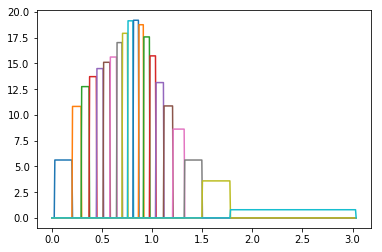

In [41]:
def plot_nz(probe):
    z = np.linspace(0, probe.zmax, 500)
    for pz in probe.params[0]:
        plt.plot(z, pz(z), '-')
        
plot_nz(B1[0])

In [42]:
%time clB1 = jc.angular_cl.angular_cl(cosmo, ell, B1)

CPU times: user 6.52 s, sys: 679 ms, total: 7.2 s
Wall time: 7.72 s


In [43]:
nlB1 = jc.angular_cl.noise_cl(ell, B1)

In [44]:
clB1.shape, nlB1.shape

((210, 100), (210, 100))

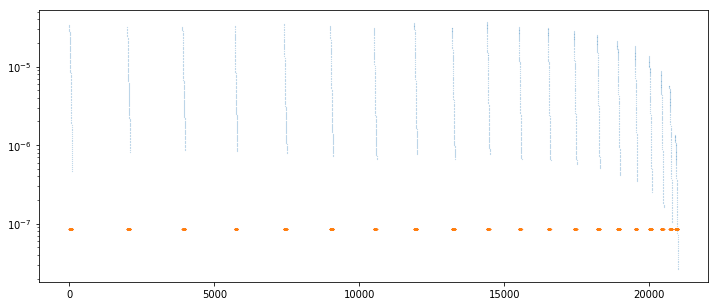

In [45]:
def plot_cl(cl, cln):
    plt.figure(figsize=(12, 5))
    plt.semilogy(cl.reshape(-1), '.', ms=0.2)
    plt.semilogy(cln.reshape(-1), '.', ms=1)
    
plot_cl(clB1, nlB1)

### Reweighted Bins

In [125]:
def init_binned_cl(zedges, what='3x2', sigma_e=0.26):
    probes = get_bin_probes(zedges, what, sigma_e, gals_per_arcmin2=1.)
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)
    nl = jc.angular_cl.noise_cl(ell, probes)
    plot_cl(cl, nl)
    return init_reweighting(probes, cl)

CPU times: user 5.83 s, sys: 443 ms, total: 6.27 s
Wall time: 5.53 s


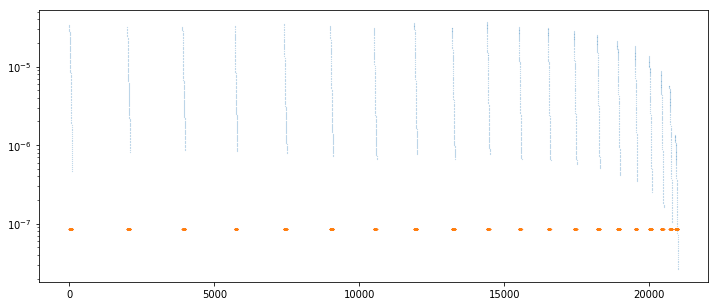

In [126]:
%time ngals, noise, cl_in = init_binned_cl(zedges, 'gg')

In [145]:
def get_binned_weights(zedges, z, idx):
    """Calculate the weight matrix for galaxies with redshifts z and corresponding output bins idx.
    
    Any galaxies with z < zedges[0] or z >= zedges[-1] contribute to the normalization only.
    """
    idx_out = np.array(idx, int)
    assert len(z) == len(idx_out)
    ntot = len(z)
    nout = idx_out.max() + 1
    nin = len(zedges) - 1
    idx_in = np.digitize(z, zedges) - 1
    inbounds = (idx_in >= 0) & (idx_in < nin)
    weights = []
    for ibin in range(nout):
        weights.append(np.bincount(idx_in[(idx_out == ibin) & inbounds], minlength=nin))
    return np.vstack(weights) / ntot

In [146]:
w = get_binned_weights(zedges, z_rf, idx_rf)

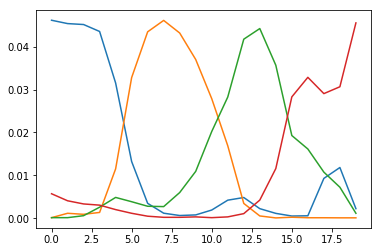

In [147]:
plt.plot(w.T);

In [206]:
def get_binned_cl_cov(weights, gals_per_arcmin2, ngals, noise, cl_in):
    
    cl_out = reweight_cl(weights, ngals, cl_in)
    nell = cl_out.shape[1]
    nl_out = reweight_noise_cl(weights, gals_per_arcmin2, ngals, noise, nell)

    return cl_out, nl_out

In [207]:
cl_out, nl_out = get_binned_cl_cov([w], 20., ngals, noise, cl_in)

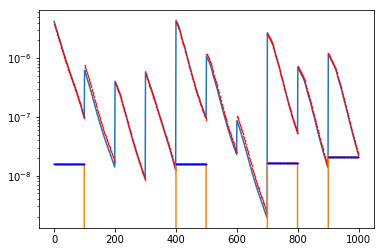

In [208]:
plt.semilogy(cl_out.reshape(-1));
plt.semilogy(cl_rf.reshape(-1), 'r.', ms=1);
plt.semilogy(nl_out.reshape(-1));
plt.semilogy(nl_rf.reshape(-1), 'b.', ms=1);

### Smail Slices

Define a redshift bin that is a slice of a Smail distribution with hard edges:

In [208]:
from jax.scipy.special import gammaln, gammaincc

In [209]:
@jax.tree_util.register_pytree_node_class
class slice_nz(jc.redshift.redshift_distribution):
    """Defines a slice of a Smail distribution.
    
    The overall distribution shape is configured by (a,b,z0) and
    its overall normalization is configured by gals_per_arcmin2.
    The particular slice to use is specified by (zlo,zhi).
    Only (zlo,zhi) are used in gradient calculations.
    zmax is used to set the upper limit for numerical c_ell integrations
    and should be set equal to the largest slide upper limit.
    """
    def __init__(self, zlo, zhi, a, b, z0, gals_per_arcmin2, zmax):
        ##assert zlo < zhi and zlo >= 0 and zhi <= zmax
        # Calculate the integral of z ** a * exp(-((z / z0) ** b))
        r = (a + 1) / b
        G = jnp.exp(gammaln(r))
        integral = z0 ** (a + 1) / b * G
        # Calculate the fraction of galaxies in [zlo,zhi] relative to [0,infty].
        slice_frac = gammaincc(r, (zlo / z0) ** b) - gammaincc(r, (zhi / z0) ** b)
        # Initialize our base class. Variables to use for autograd must be
        # passed via *args and all others via **kwargs.
        super(slice_nz, self).__init__(
            zlo, zhi, # autograd variables
            a=a, b=b, z0=z0, # other config we need
            gals_per_arcmin2=gals_per_arcmin2 * slice_frac, zmax=zmax # base-class config
        )
        # Do not perform numerical normalization.
        self._norm_factor = gals_per_arcmin2 / integral
        self._norm = slice_frac * integral
    
    def pz_fn(self, z):
        """Evaluate the galaxy density dn/dz in this slice.
        """
        zlo, zhi = self.params
        a, b, z0 = self.config['a'], self.config['b'], self.config['z0']
        locut = (1 + jnp.sign(z - zlo)) / 2
        hicut = (1 - jnp.sign(z - zhi)) / 2
        return z ** a * jnp.exp(-((z / z0) ** b)) * locut * hicut * self._norm_factor
    
    def __call__(self, z):
        zlo, zhi = self.params
        a, b, z0 = self.config['a'], self.config['b'], self.config['z0']
        locut = (1 + jnp.sign(z - zlo)) / 2
        hicut = (1 - jnp.sign(z - zhi)) / 2
        return z ** a * jnp.exp(-((z / z0) ** b)) * locut * hicut / self._norm

Generate probes using redshift slices. When using both `g` and `w`, the same slices are used for both.

In [210]:
def get_slice_probes(zedges, what='gg', sigma_e=0.26, gals_per_arcmin2=40, a=1, b=2, z0=1, zmax=2.5):
    
    # Add the fixed outer edges.
    zedges = jnp.concatenate((jnp.array([0.]), jnp.asarray(zedges), jnp.array([zmax])))
    nzbins = len(zedges) - 1
    
    # Build the redshift bins.
    zbins = []
    for i in range(nzbins):
        zbin = slice_nz(
            zedges[i], zedges[i + 1],
            a=a, b=b, z0=z0,
            gals_per_arcmin2=gals_per_arcmin2, zmax=zmax)
        zbins.append(zbin)
        
    probes = []
    # start with number counts
    if (what == 'gg' or what == '3x2'):
        # Define a bias parameterization
        bias = jc.bias.inverse_growth_linear_bias(1.)
        probes.append(jc.probes.NumberCounts(zbins, bias))

    if (what == 'ww' or what == '3x2'):
        probes.append(jc.probes.WeakLensing(zbins, sigma_e=sigma_e))

    return probes

In [211]:
P1 = get_slice_probes([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0], '3x2')

In [212]:
P2 = get_slice_probes([0.5, 1.0, 1.5], '3x2')

In [213]:
%time cl1 = jc.angular_cl.angular_cl(cosmo, ell, P1)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 9.23 s, sys: 881 ms, total: 10.1 s
Wall time: 11.5 s


In [214]:
%time cl2 = jc.angular_cl.angular_cl(cosmo, ell, P2)

CPU times: user 8.18 s, sys: 341 ms, total: 8.52 s
Wall time: 8.58 s


In [215]:
noise1 = jc.angular_cl.noise_cl(ell, P1)

In [216]:
noise2 = jc.angular_cl.noise_cl(ell, P2)

In [217]:
cl1.shape, cl2.shape, noise1.shape, noise2.shape

((136, 100), (36, 100), (136, 100), (36, 100))

In [218]:
ngals, cl_in, cl_noise_in = init_reweighting(P1, cl1, noise1)

In [219]:
weights = [
    [[1,1,0,0,0,0,0,0], [0,0,1,1,0,0,0,0], [0,0,0,0,1,1,0,0], [0,0,0,0,0,0,1,1]],
    [[1,1,0,0,0,0,0,0], [0,0,1,1,0,0,0,0], [0,0,0,0,1,1,0,0], [0,0,0,0,0,0,1,1]]
]

In [220]:
cl_out, cl_noise_out = do_reweight_angular_cl(weights, ngals, cl_in, cl_noise_in)

In [221]:
#cl12 = reweighted_angular_cl(cl1, P1, weights, False)

In [222]:
#noise12 = reweighted_angular_cl(noise1, P1, weights, True)

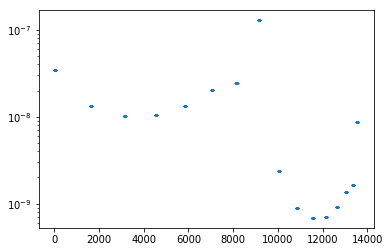

In [223]:
plt.semilogy(noise1.reshape(-1), '.', ms=1);

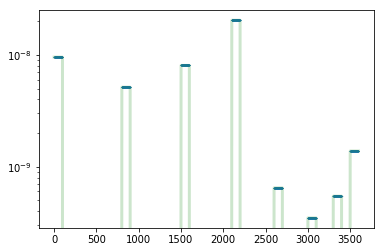

In [224]:
plt.semilogy(noise2.reshape(-1), '.', ms=1)
#plt.semilogy(noise12.reshape(-1), 'r-', lw=3, alpha=0.2);
plt.semilogy(cl_noise_out.reshape(-1), 'g-', lw=3, alpha=0.2);

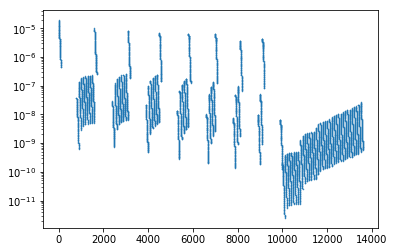

In [225]:
plt.semilogy(cl1.reshape(-1), '.', ms=1);

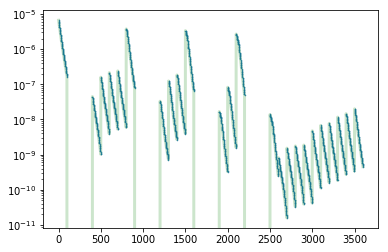

In [226]:
plt.semilogy(cl2.reshape(-1), '.', ms=1)
#plt.semilogy(cl12.reshape(-1), 'r-', lw=3, alpha=0.2);
plt.semilogy(cl_out.reshape(-1), 'g-', lw=3, alpha=0.2);